In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip drive/MyDrive/'Colab Notebooks'/PhC-C2DH-U373.zip

Archive:  drive/MyDrive/Colab Notebooks/PhC-C2DH-U373.zip
   creating: PhC-C2DH-U373/
   creating: PhC-C2DH-U373/01/
  inflating: PhC-C2DH-U373/01/t000.tif  
  inflating: PhC-C2DH-U373/01/t001.tif  
  inflating: PhC-C2DH-U373/01/t002.tif  
  inflating: PhC-C2DH-U373/01/t003.tif  
  inflating: PhC-C2DH-U373/01/t004.tif  
  inflating: PhC-C2DH-U373/01/t005.tif  
  inflating: PhC-C2DH-U373/01/t006.tif  
  inflating: PhC-C2DH-U373/01/t007.tif  
  inflating: PhC-C2DH-U373/01/t008.tif  
  inflating: PhC-C2DH-U373/01/t009.tif  
  inflating: PhC-C2DH-U373/01/t010.tif  
  inflating: PhC-C2DH-U373/01/t011.tif  
  inflating: PhC-C2DH-U373/01/t012.tif  
  inflating: PhC-C2DH-U373/01/t013.tif  
  inflating: PhC-C2DH-U373/01/t014.tif  
  inflating: PhC-C2DH-U373/01/t015.tif  
  inflating: PhC-C2DH-U373/01/t016.tif  
  inflating: PhC-C2DH-U373/01/t017.tif  
  inflating: PhC-C2DH-U373/01/t018.tif  
  inflating: PhC-C2DH-U373/01/t019.tif  
  inflating: PhC-C2DH-U373/01/t020.tif  
  inflating: PhC-C2DH-

In [7]:
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import backend as K

In [8]:
from PIL import Image #libreria para mirar imagenes

In [9]:
from tensorflow.keras.models import Sequential

# **Cargo data de Train y Val**

(te estas portando mal...) Train será aumentada

In [10]:
train_path = Path("PhC-C2DH-U373/01/").glob("**/*tif") #para el directorio indicado, dame los paths completos de todos los archivos
val_path = Path("PhC-C2DH-U373/02/").glob("**/*tif")

In [11]:
#generadores con archivos de training
train_images = list()
train_masks = list()
for file in train_path:
    train_images.append(np.array(Image.open(file)).reshape(1,520,696))
    train_masks.append(np.array(Image.open(f'PhC-C2DH-U373/01_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

#generadores con archivos de validacion
val_images = list()
val_masks = list()

for file in val_path:
    val_images.append(np.array(Image.open(file)).reshape(1,520,696))
    val_masks.append(np.array(Image.open(f'PhC-C2DH-U373/02_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

Normalizamos dataset

In [12]:
train_images = np.vstack(train_images)/255  #vertical stack: stack con axis = 0. Nos quedan 115 imagenes (duracion del video) de 520x696
train_masks = 1*(np.vstack(train_masks) > 0) #el >0 nos dice que si hay algun tipo de notacion, ponga un 1, sino un 0. De esta forma nos da un detector binario.
val_images = np.vstack(val_images)/255
val_masks = 1*(np.vstack(val_masks) >0 )

# Imágenes de train sin aumentar

Miramos las imagenes sin aumentar. Se puso un alpha de 0.6 para que haya una cierta transparencia en las imagenes.

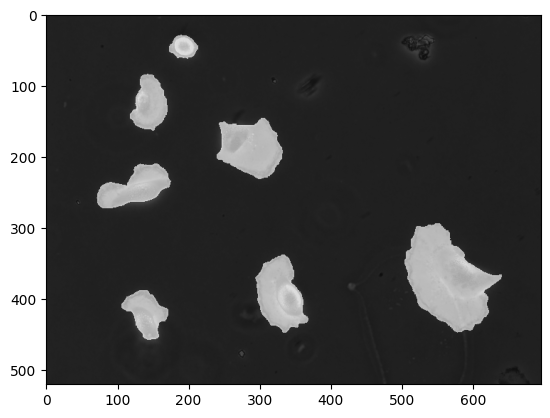

In [13]:
idx = 100
plt.imshow(train_images[idx], vmin=0, vmax=1, cmap="gray")
plt.imshow(train_masks[idx], vmin=0, vmax=1, cmap="gray",alpha=0.6)
plt.show()

# Armo datasets de tensorflow y aumento

Para mantener sincronizada la aumentación entre la imagen y la máscara, armo una entrada de 4 canales que de descompondrán durante el entrenamiento. Lo hacemos tanto para train como para validacion. 0 es la imagen, 1 es la mascara.

In [14]:
x_train = np.stack((train_images, train_masks ),axis=-1)
x_val = np.stack((val_images, val_masks ),axis=-1)

In [15]:
x_train[0,:,:,0].max()

0.7254901960784313

In [16]:
len(x_train) #tenemos 115 imagenes

115

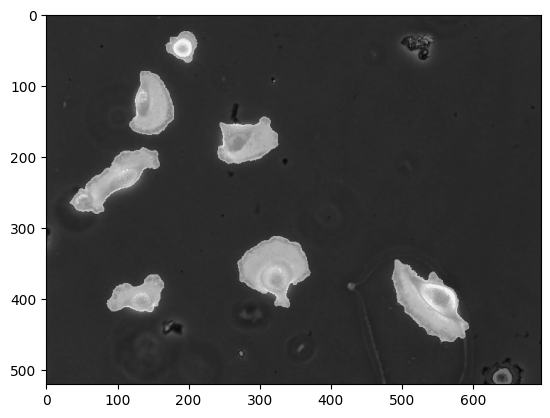

In [17]:
plt.imshow(x_train[0,:,:,0], cmap="gray")
plt.imshow(x_train[0,:,:,1], cmap="gray", alpha = 0.5)

# Armo una red mínima fully convolutional con Atrous Convolutions

**Problema de usar unicamente convolucionales:** el campo perceptual crece linealmente. Si usamos un kernel de 3x3 voy a necesitar 50 capas aprox para tener un campo perceptual del orden de la celula (aprox 100x100), en caso de no tener max pooling.  
**Solución:** **Atrous convolution** o **dilated convolutions** permite hacer crecer el campo perceptual sin usar max pooling al imponer un dilation rate, es decir la separacion entre pixeles del feature map de entrada, se obtiene un mayor campo perceptual a un menor costo. Es un analisis en "baja frecuencia" del feature map de entrada.

In [18]:
#NOTA: no hace falta indicar el tamaño de la imagen de entrada porque es una red fully convolutional y no hay un flatten que necesite un tamaño fijo de vector
filters = 16
kernel_size = 10
def get_red_seg():
    return Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1, input_shape = (None,None,1)),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 2),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 4),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 8),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1),
        tf.keras.layers.Conv2D(1, kernel_size,padding="same", activation = "sigmoid", dilation_rate = 1)
    ])


# Armo la red de preprocesamiento para hacer aumentación en la GPU que no tengo

In [19]:
def get_preproc():
    return Sequential([
        tf.keras.layers.RandomCrop(512,512),
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        #tf.keras.layers.RandomZoom((-0.1,0.3)),
        #tf.keras.layers.RandomTranslation((-0.5, 0.5), (-0.5,0.5)),
        #tf.keras.layers.RandomRotation((0,1)),
        #tf.keras.layers.RandomZoom((0.5,0.5)),
        ])

def get_preproc_val():
    return Sequential([
        tf.keras.layers.CenterCrop(512,512),
        ])

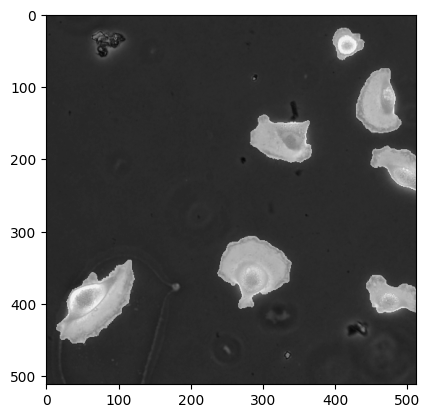

In [20]:
preproc = get_preproc()
aux_elem = preproc(x_train[0])
plt.imshow(aux_elem[:,:,0], cmap="gray")
plt.imshow(aux_elem[:,:,1], cmap="gray", alpha = 0.5)

In [21]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

## Definimos la red de segmentacion: preprocesamiento, mascaras, etc.

In [22]:
class SegmentationModel(Model):
    def __init__(self, red_preproc, red_segmentacion, red_preproc_val):
        super().__init__()
        self.red_segmentacion = red_segmentacion
        self.red_preproc = red_preproc
        self.red_preproc_val = red_preproc_val
        self.loss_tracker = metrics.Mean(name="loss")
        self.dice = False

    #El call es cuando se utiliza la red para hacer prediccion. Agarra la entrada y la pasa por la red de segmentacion.
    def call(self, inputs):
        #img_mask = self.red_preproc = red_preproc(inputs)
        return self.red_segmentacion(inputs[:,:,:1])

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            data_aug = self.red_preproc(data)
            loss = self._compute_loss(data_aug)
            #print(K.mean(loss))

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.red_segmentacion.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.red_segmentacion.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)    #informar la loss a medida que va entrenando.
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        data_preproc = self.red_preproc_val(data)
        loss = self._compute_loss(data_preproc)
        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    #La loss es un tensor asociado a un grafo y con eso calcula un gradiente.
    def _compute_loss(self, data):
        #aux = self.red_preproc(data)
        mask_out = self.red_segmentacion(data[:,:,:,:1])
        #print(mask_out.shape)
        #print(data[:,:,:,1:2].numpy())
        if self.dice == True:
            loss = dice_loss(data[:,:,:,1:2], mask_out)
        else:
            loss = tf.keras.losses.binary_crossentropy(data[:,:,:,1:2], mask_out)
        return loss

    #aca van las metricas a medida que se va entrenando.
    # property
    # def metrics(self):
    #     # We need to list our metrics here so the `reset_states()` can be
    #     # called automatically.
    #     return [self.loss_tracker]

Instanciamos la red de segmentacion.

In [23]:
red_falopa = get_red_seg() #falopa: del griego, mala calidad.

In [24]:
red_falopa.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    1616      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 105,681
Trainable params: 105,681
Non-tr

Armamos la red de pre procesamiento.

In [25]:
preproc= get_preproc()
preproc_val = get_preproc_val()
red_falopa = get_red_seg()
model = SegmentationModel(preproc, red_falopa,preproc_val)

Le decimos a la red qué optimizador utilizar.

In [26]:
model.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [27]:
len(x_val)

115

In [28]:
model.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
8/8 [==============================] - 76s 2s/step - loss: 0.6860 - val_loss: 0.6603
Epoch 2/100
8/8 [==============================] - 8s 1s/step - loss: 0.6256 - val_loss: 0.4829
Epoch 3/100
8/8 [==============================] - 8s 1s/step - loss: 0.4107 - val_loss: 0.1702
Epoch 4/100
8/8 [==============================] - 8s 1s/step - loss: 0.3805 - val_loss: 0.2097
Epoch 5/100
8/8 [==============================] - 8s 1s/step - loss: 0.3419 - val_loss: 0.2354
Epoch 6/100
8/8 [==============================] - 8s 1s/step - loss: 0.3343 - val_loss: 0.1797
Epoch 7/100
8/8 [==============================] - 8s 1s/step - loss: 0.3345 - val_loss: 0.2014
Epoch 8/100
8/8 [==============================] - 8s 1s/step - loss: 0.3265 - val_loss: 0.1968
Epoch 9/100
8/8 [==============================] - 8s 1s/step - loss: 0.3243 - val_loss: 0.1869
Epoch 10/100
8/8 [==============================] - 8s 1s/step - loss: 0.3219 - val_loss: 0.1952
Epoch 11/100
8/8 [====================

In [29]:
pred = red_falopa(x_val[0:1,:,:,0])
pred.shape

TensorShape([1, 520, 696, 1])

In [30]:
pred.numpy().max() #me fijo valores entre 0 y 1, asi que deberia estar cerca de 1 el max.

0.99841595

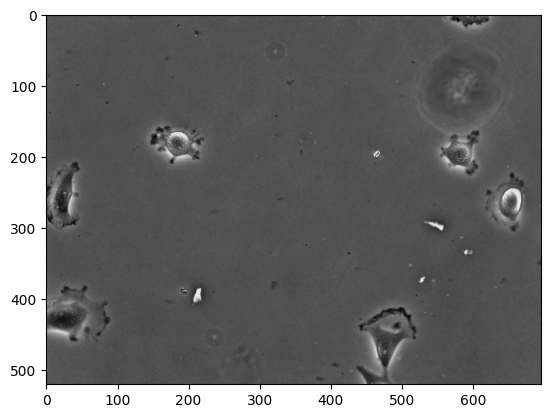

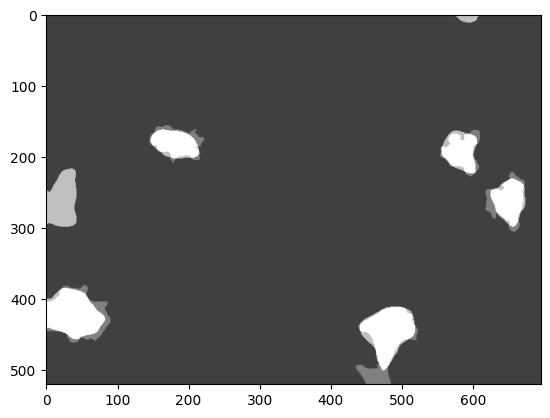

In [31]:
plt.imshow(x_val[0,:,:,0], cmap="gray") #imagen
plt.show()
plt.imshow(x_val[0,:,:,1], cmap="gray", alpha=0.5) #anotacion
plt.imshow(pred[0,:,:,0]>0.5, cmap="gray", alpha=0.5) #prediccion de la red
plt.show() #comparamos anotacion y prediccion

In [32]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D,Conv2DTranspose

## Implementación de la arquitectura UNet

Se lo dividió en tres funciones, en orden de abstraccion creciente.
*   **Conv_block:** define un bloque convolucional, el bloque constitutivo de la UNet.
*  **level_block:** funcion recursiva que va creando los niveles de los distintos Conv_block, mediante max pooling (ir reduciendo el feature map), hasta que la profundidad es 0, empieza a hacer upsampling
*  **UNet:** crea instancia de arquitectura UNet segun parametros indicados.




In [33]:
#imagen de entrada
img_shape = (512, 512, 1)
################################################################################
#	Conv_block: define un bloque convolucional, el bloque constitutivo de la UNet
################################################################################
def conv_block(m,			#tensor de entrada al bloque
              dim,		#numero de filtros en las capas convolucionales (13 porque usamos kernels de tamaño 3)
							acti, 	#funcion de activacion a utilizar
							bn,			#flag para aplicar o no batch normalization
							res,	 	#flag para aplicar o no conexiones residuales
							do=0): 	#droupout rate
	#Conv2D: realiza una convolucion 2D del tensor m utilizando dim filtros de tamaño 3x3 con la funcion de activacion acti y un padding para mantener el campo perceptual.
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	#Batch normalization si bn es true
	n = BatchNormalization()(n) if bn else n
	#Droupout si do es true
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	# return concatena los canales de entrada con la salida si res es true.
	# Esto es por si se quiere un skip conection entre entrada y salida, acelerando el entrenamiento
	return Concatenate()([m, n]) if res else n

################################################################################
#	level_block: 	representa un nivel de la arquitectura UNet.
#								se trata de una funcion recursiva, por lo que se realiza segun depth determinado.
################################################################################
def level_block(m,	#tensor de entrada al nivel
                dim, #numero de filtros en las capas convolucionales
								depth,	#profundidad o nivel del bloque en la estructura UNet.
								inc,		#la rate a la que el numero de filtros se incrementa con cada nivel.
								acti,		#funcion de activacion
								do,			#dropout rate
								bn,			#flag para aplicar o no batch normalization
								mp,			#flag para aplicar o no max pooling
								up,			#flag para aplicar o no upsampling
								res):		#flag para aplicar o no conexiones residuales

	#se evalua si quedan niveles a ser procesados.
	if depth > 0:
		#realiza una operacion convolucional mediante la funcion conv_block
		n = conv_block(m, dim, acti, bn, res)
		#si mp == true, aplica max pooling para downsamplear el campo perceptual.
		#si mp == false, realiza una convolucion 2D para downsamplear con stride de 2 a los canales.
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		#Recursion. La profundidad baja en un 1 y el numero de filtros se incrementa por el inc.
		#La recursion continua hasta que depth == 0.
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)

		#Esta parte trata con la parte de upsampling.
		#Primero se lo upsamplea y luego se aplica una convolucion 2D.
		#Si el flag de up == false, se aplica una conv2DTranspose para el upsampling.
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)

		#Esta parte realiza la skip conection. Concatena el feature map n ants del downsampling
		#con el m que sufrio el upsampling, de modo de combinar informacion de iguales niveles.
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

################################################################################
#	UNet: Llama a las funciones Conv_block y level_block y les da forma de arq UNET.
################################################################################
def UNet(img_shape,
        out_ch=1,	#nro de canales de salida. 1 por default para segmentacion binaria.
				start_ch=64,	#nro de filtros en primera capa. Default 64.
				depth=4,	#nro de niveles en la estructura UNet.
				inc_rate=2.,	#tasa a la que el numero de filtros se incrementa con cada nivel.
				activation='relu', #funcion de activacion.
		 		dropout=0.5,	#dropout rate.
				batchnorm=False,	#flag para aplicar o no batch normalization
				maxpool=True, #flag para aplicar o no max pooling
				upconv=True, #flag para aplicar o no upsampling mediante transposed convolutions.
				residual=False):	#flag para aplicar o no conexiones residuales
	i = Input(shape=img_shape)
	#crea la estructura UNet utilizando level_block con el numero de canales, profundidad y demas parametros.
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
 	#La ultima capa es una activacion sigmoidea con un canal
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)		#Instanciacion del modelo

In [34]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,  #queremos ver si overfittea.
    residual = True
)
#instanciamos la red
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)

In [35]:
model_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [36]:
model_unet.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
8/8 [==============================] - 52s 3s/step - loss: 0.6199 - val_loss: 0.5577
Epoch 2/100
8/8 [==============================] - 12s 1s/step - loss: 0.5205 - val_loss: 0.3024
Epoch 3/100
8/8 [==============================] - 12s 1s/step - loss: 0.3732 - val_loss: 0.2057
Epoch 4/100
8/8 [==============================] - 12s 1s/step - loss: 0.3626 - val_loss: 0.2480
Epoch 5/100
8/8 [==============================] - 12s 2s/step - loss: 0.3515 - val_loss: 0.2016
Epoch 6/100
8/8 [==============================] - 12s 2s/step - loss: 0.3425 - val_loss: 0.2190
Epoch 7/100
8/8 [==============================] - 12s 2s/step - loss: 0.3434 - val_loss: 0.2074
Epoch 8/100
8/8 [==============================] - 14s 2s/step - loss: 0.3271 - val_loss: 0.1947
Epoch 9/100
8/8 [==============================] - 12s 1s/step - loss: 0.3213 - val_loss: 0.1925
Epoch 10/100
8/8 [==============================] - 12s 2s/step - loss: 0.3062 - val_loss: 0.1576
Epoch 11/100
8/8 [===========

In [37]:
red_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 512, 512, 16  2320        ['conv2d_12[0][0]']              
                                )                                                             

In [38]:
aux = preproc_unet_val(x_val[0:1,:,:,:])
pred = red_unet(aux[0:1,:,:,0])
pred.shape

TensorShape([1, 512, 512, 1])

El predicho es superior a la red sin estrucrura UNet. El anterior fue 0.9984159.

In [39]:
pred.numpy().max()

0.9998246

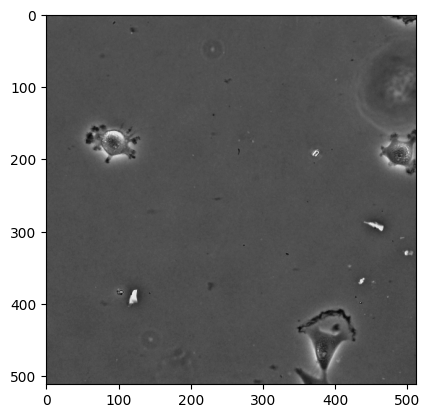

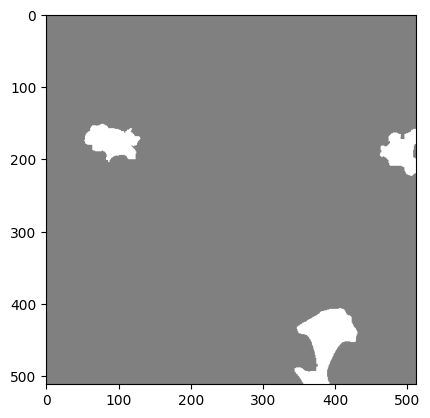

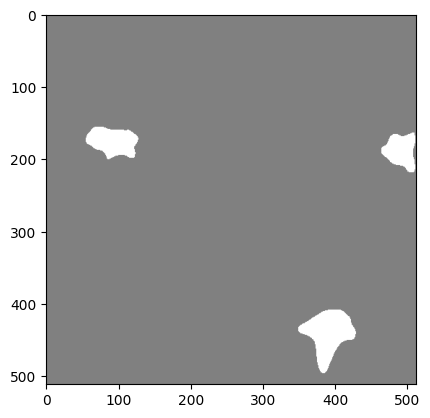

In [40]:
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha = 0.5)
plt.show()
plt.imshow(pred[0,:,:,0]>0.7, cmap="gray", alpha = 0.5)
plt.show()

## Dice Coefficient y dice loss:
Es una medida de similaridad entre las dos máscaras. Computa la intersección entre las dos máscaras, suma sus valores y aplica la fórmula del coeficiente de Dice. Luego se computa la dice_loss como 1-dice_coeff.


In [42]:
model_unet.dice = True #activamos el computo del dice_loss en el modelo

In [44]:
model_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-4))
red_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 512, 512, 16  2320        ['conv2d_12[0][0]']              
                                )                                                             

In [45]:
model_unet.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
8/8 [==============================] - 21s 2s/step - loss: 0.3801 - val_loss: 0.3138
Epoch 2/100
8/8 [==============================] - 12s 2s/step - loss: 0.1959 - val_loss: 0.2311
Epoch 3/100
8/8 [==============================] - 12s 2s/step - loss: 0.1330 - val_loss: 0.2019
Epoch 4/100
8/8 [==============================] - 12s 2s/step - loss: 0.0948 - val_loss: 0.1673
Epoch 5/100
8/8 [==============================] - 14s 2s/step - loss: 0.0853 - val_loss: 0.1481
Epoch 6/100
8/8 [==============================] - 14s 2s/step - loss: 0.0755 - val_loss: 0.1364
Epoch 7/100
8/8 [==============================] - 14s 2s/step - loss: 0.0669 - val_loss: 0.1399
Epoch 8/100
8/8 [==============================] - 12s 2s/step - loss: 0.0619 - val_loss: 0.1348
Epoch 9/100
8/8 [==============================] - 15s 2s/step - loss: 0.0600 - val_loss: 0.1254
Epoch 10/100
8/8 [==============================] - 12s 2s/step - loss: 0.0551 - val_loss: 0.1285
Epoch 11/100
8/8 [===========

In [46]:
aux = preproc_unet_val(x_val[0:1,:,:,:])
pred = red_unet(aux[0:1,:,:,0])
pred.shape

TensorShape([1, 512, 512, 1])

Y se puede observar que, para este problema y dataset, en principio obtuvimos una mejor prediccion.

In [49]:
pred.numpy().max()

1.0

La segmentacion predicha de la de validación resultan casi iguales.

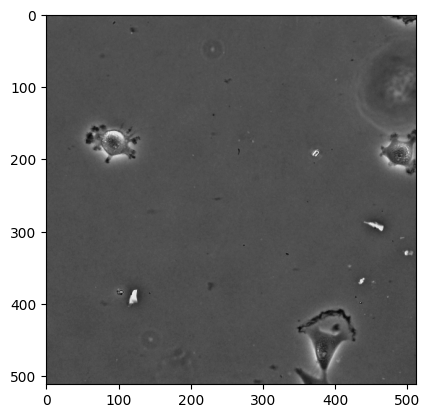

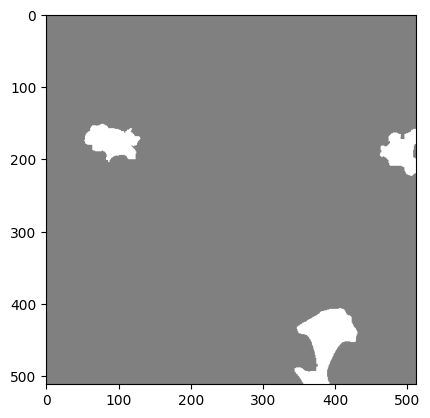

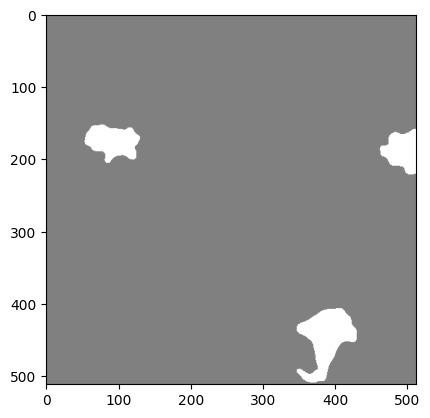

In [50]:
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha = 0.5)
plt.show()
plt.imshow(pred[0,:,:,0]>0.7, cmap="gray", alpha = 0.5)
plt.show()

### Agregamos Dropout rate
Solo por comparar, veamos si agregando un dropout rate mejoramos el modelo, aunque como vimos, no queda tanto más por mejorar. Quizás convendría agregarlo con el cómputo anterior de la binary crossentropy.


In [51]:
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = 0.5,  #queremos ver si overfittea.
    residual = True
)
#instanciamos la red
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)
model_unet.dice = True #activamos el computo del dice_loss en el modelo

In [52]:
model_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-4))
red_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_35 (Conv2D)             (None, 512, 512, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 512, 512, 16  2320        ['conv2d_35[0][0]']              
                                )                                                           

In [53]:
model_unet.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
8/8 [==============================] - 22s 2s/step - loss: 0.8487 - val_loss: 0.9326
Epoch 2/100
8/8 [==============================] - 14s 2s/step - loss: 0.8408 - val_loss: 0.9299
Epoch 3/100
8/8 [==============================] - 12s 2s/step - loss: 0.8266 - val_loss: 0.9298
Epoch 4/100
8/8 [==============================] - 12s 2s/step - loss: 0.8269 - val_loss: 0.9275
Epoch 5/100
8/8 [==============================] - 12s 1s/step - loss: 0.8237 - val_loss: 0.9264
Epoch 6/100
8/8 [==============================] - 12s 1s/step - loss: 0.8272 - val_loss: 0.9246
Epoch 7/100
8/8 [==============================] - 12s 2s/step - loss: 0.8136 - val_loss: 0.9177
Epoch 8/100
8/8 [==============================] - 12s 1s/step - loss: 0.7864 - val_loss: 0.8902
Epoch 9/100
8/8 [==============================] - 12s 2s/step - loss: 0.7363 - val_loss: 0.8805
Epoch 10/100
8/8 [==============================] - 12s 1s/step - loss: 0.7286 - val_loss: 0.8747
Epoch 11/100
8/8 [===========

In [54]:
aux = preproc_unet_val(x_val[0:1,:,:,:])
pred = red_unet(aux[0:1,:,:,0])
pred.shape

TensorShape([1, 512, 512, 1])

In [55]:
pred.numpy().max()

1.0

Podemos ver que la predicción empeoró respecto a la corrida anterior.

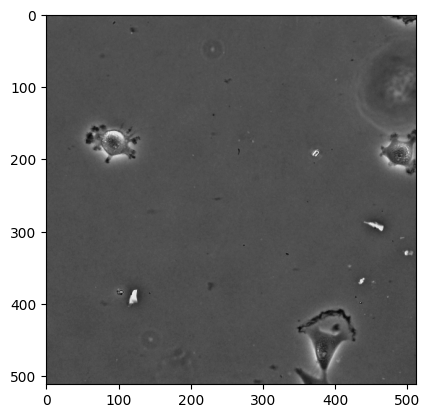

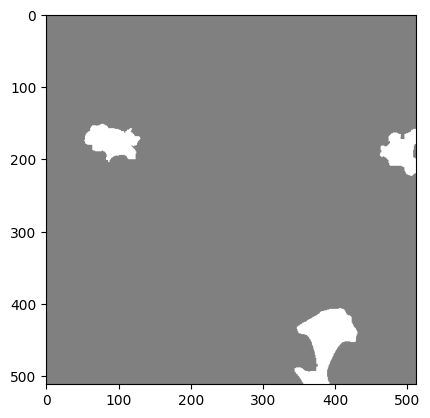

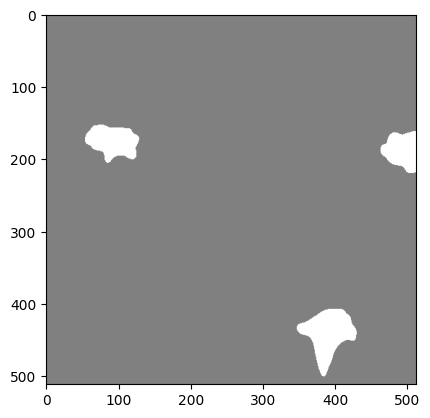

In [56]:
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha = 0.5)
plt.show()
plt.imshow(pred[0,:,:,0]>0.7, cmap="gray", alpha = 0.5)
plt.show()